# Transfer learning and fine-tuning

In this tutorial, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

You will follow the general machine learning workflow.

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Data preprocessing

### Data download

In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.utils.image_dataset_from_directory` utility. You can learn more about loading images in this [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

In [2]:
training_dir = 'dataset/training'
validation_dir = 'dataset/validation'
test_dir = 'dataset/test'

BATCH_SIZE = 32
IMG_SIZE = (150, 150)

In [3]:
training_dataset = tf.keras.utils.image_dataset_from_directory(training_dir,
                                                               shuffle=True,
                                                               batch_size=BATCH_SIZE,
                                                               image_size=IMG_SIZE)

Found 13140 files belonging to 6 classes.


In [4]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2580 files belonging to 6 classes.


Show the first nine images and labels from the training set:

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting.

In [5]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Let's repeatedly apply these layers to the same image and see the result.

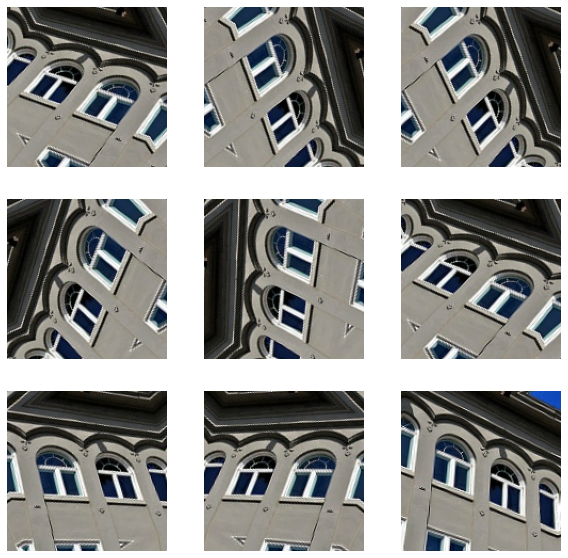

In [6]:
for image, _ in training_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [7]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [8]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

This feature extractor converts each `150x150x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [9]:
image_batch, label_batch = next(iter(training_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [10]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [11]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image.

In [12]:
prediction_layer = tf.keras.layers.Dense(6)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 6)


Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [13]:
inputs = tf.keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [14]:
base_model.trainable = True

In [15]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [16]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=0.00001)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer = opt,
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 150, 150, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 150, 150, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [18]:
history_fine = model.fit(training_dataset,
                         epochs=20,
                         validation_data=validation_dataset)

Epoch 1/20
411/411 [==============================] - 142s 338ms/step - loss: 2.5715 - accuracy: 0.4782 - val_loss: 1.4293 - val_accuracy: 0.4764
Epoch 2/20
411/411 [==============================] - 143s 347ms/step - loss: 1.3590 - accuracy: 0.6082 - val_loss: 1.0519 - val_accuracy: 0.7023
Epoch 3/20
411/411 [==============================] - 143s 348ms/step - loss: 1.4114 - accuracy: 0.6559 - val_loss: 1.0773 - val_accuracy: 0.7523
Epoch 4/20
411/411 [==============================] - 139s 337ms/step - loss: 1.2282 - accuracy: 0.7005 - val_loss: 1.0013 - val_accuracy: 0.7926
Epoch 5/20
411/411 [==============================] - 139s 338ms/step - loss: 1.4929 - accuracy: 0.6105 - val_loss: 0.9125 - val_accuracy: 0.7310
Epoch 6/20
411/411 [==============================] - 139s 337ms/step - loss: 1.0440 - accuracy: 0.7092 - val_loss: 0.7914 - val_accuracy: 0.8430
Epoch 7/20
411/411 [==============================] - 138s 337ms/step - loss: 1.2947 - accuracy: 0.6456 - val_loss: 1.0937 -

After fine tuning the model nearly reaches 98% accuracy on the validation set.

### Evaluation and prediction

Finaly you can verify the performance of the model on new data using test set.

In [19]:
loss, accuracy = model.evaluate(validation_dataset)
print('Test accuracy :', accuracy)

81/81 [==============================] - 16s 194ms/step - loss: 0.8385 - accuracy: 0.8120
Test accuracy : 0.8120155334472656


And now you are all set to use this model to predict if your pet is a cat or dog.

In [59]:
import pathlib

class_names = training_dataset.class_names

dataset_dir = pathlib.Path('dataset')

dataset_test_dir = list(dataset_dir.glob('test/*'))

for i in range(10):
    path_to_file = str(dataset_test_dir[i])
    img = tf.keras.utils.load_img(path_to_file, target_size=IMG_SHAPE)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    print("This image most likely belongs to {} with a {:.2f} percent confidence."
          .format(class_names[np.argmax(score)], 100 * np.max(score)))
    

This image most likely belongs to mountain with a 48.81 percent confidence.
This image most likely belongs to sea with a 93.85 percent confidence.
This image most likely belongs to mountain with a 83.08 percent confidence.
This image most likely belongs to forest with a 95.34 percent confidence.
This image most likely belongs to mountain with a 52.09 percent confidence.
This image most likely belongs to glacier with a 48.21 percent confidence.
This image most likely belongs to building with a 93.33 percent confidence.
This image most likely belongs to forest with a 97.65 percent confidence.
This image most likely belongs to building with a 40.92 percent confidence.
This image most likely belongs to forest with a 99.49 percent confidence.


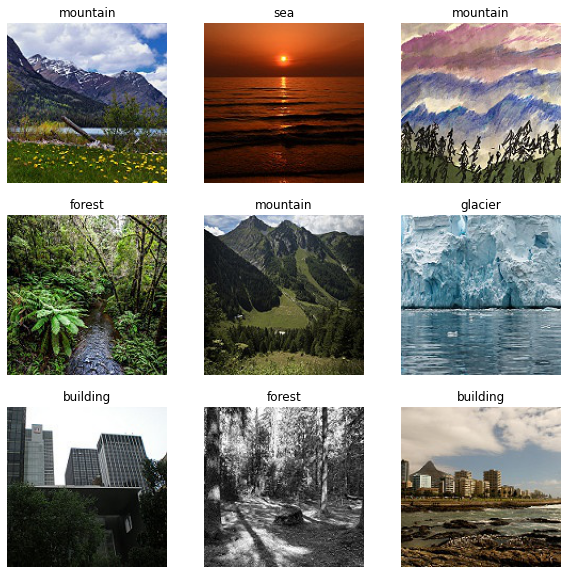

In [60]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  path_to_file = str(dataset_test_dir[i])
  img = tf.keras.utils.load_img(path_to_file, target_size=IMG_SHAPE)
  img_array = tf.keras.utils.img_to_array(img)
  
  plt.imshow(img_array.astype("uint8"))

  img_array = tf.expand_dims(img_array, 0) # Create a batch
  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  plt.title(class_names[np.argmax(score)])

  plt.axis("off")